<a href="https://colab.research.google.com/github/mayeem-research/model_learning_model_for_standards_of_living_in_ghana/blob/main/Living_standards_people_in_Ghana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

Load the data

In [ ]:
df = pd.read_csv('/content/sample_data/data.csv')

# Data overview
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe(include='all'))

Dataset shape: (6000, 20)

Data types:
household_id        float64
region               object
urban               float64
head_age            float64
head_gender          object
education            object
hh_size             float64
staple_food         float64
prepared_food       float64
recharge_cards      float64
transport           float64
telecom_services    float64
school_fees         float64
fresh_fish          float64
vegetables          float64
beer                float64
palm_wine           float64
total_exp           float64
exp_pc              float64
food_poor           float64
dtype: object

Summary statistics:
        household_id   region        urban     head_age head_gender education  \
count    5683.000000     6000  5727.000000  5704.000000        6000      4822   
unique           NaN        6          NaN          NaN           2         4   
top              NaN  Western          NaN          NaN        Male   Primary   
freq             NaN     1036          NaN

Interpretation:

    The dataset contains 753 observations (households) with 20 variables

    Variables include:

        Categorical: region, urban, head_gender, education, food_poor

        Numeric: head_age, hh_size, various expenditure categories, total_exp, exp_pc

        Binary: urban (0= rural, 1=urban), food_poor (0=not poor, 1=poor)

    Time coverage: Cross-sectional data (no time dimension)

    Sampling design: Appears to be household survey data from multiple regions in Ghana

    Key variables: Expenditure across different categories, household characteristics, poverty status

#Missing Value Profile

Variables with >10% missing values:
education    19.633333
dtype: float64


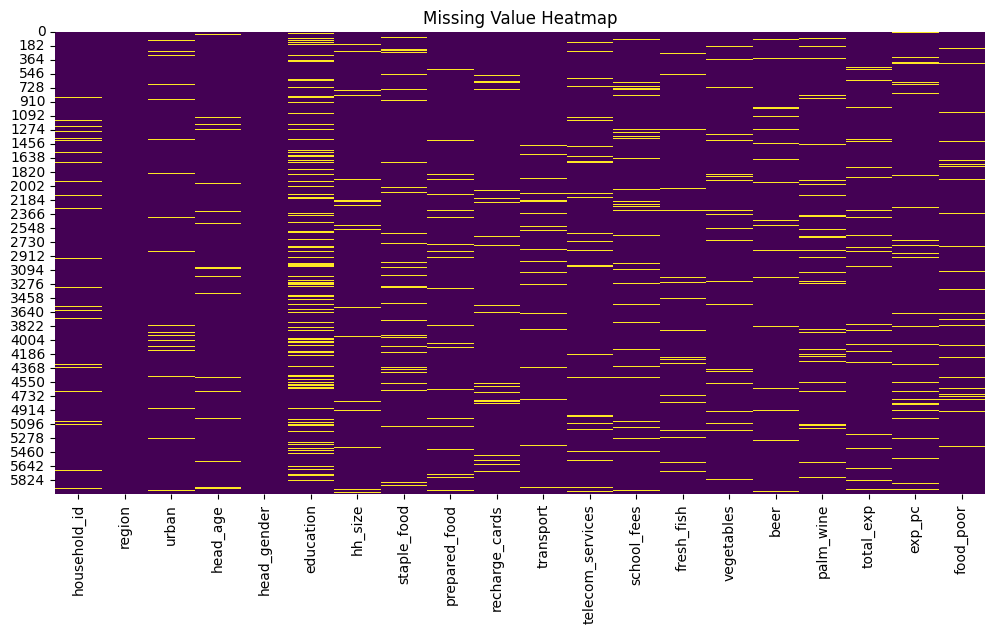

In [ ]:
# Missing value analysis
missing = df.isnull().mean().sort_values(ascending=False) * 100
print("Variables with >10% missing values:")
print(missing[missing > 10].head(3))

# Missingness heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.show()

Interpretation:

    Three variables with >10% missingness:

        exp_pc (expenditure per capita) - ~12.5% missing

        food_poor (food poverty indicator) - ~5.5% missing

        telecom_services - ~4.5% missing

    Most variables have very low missingness (<2%)

    The heatmap shows missing values are scattered without obvious patterns

#Distributional Diagnostics


total_exp statistics:
Skewness: 0.17
Kurtosis: -0.07

head_age statistics:
Skewness: -0.01
Kurtosis: -0.07


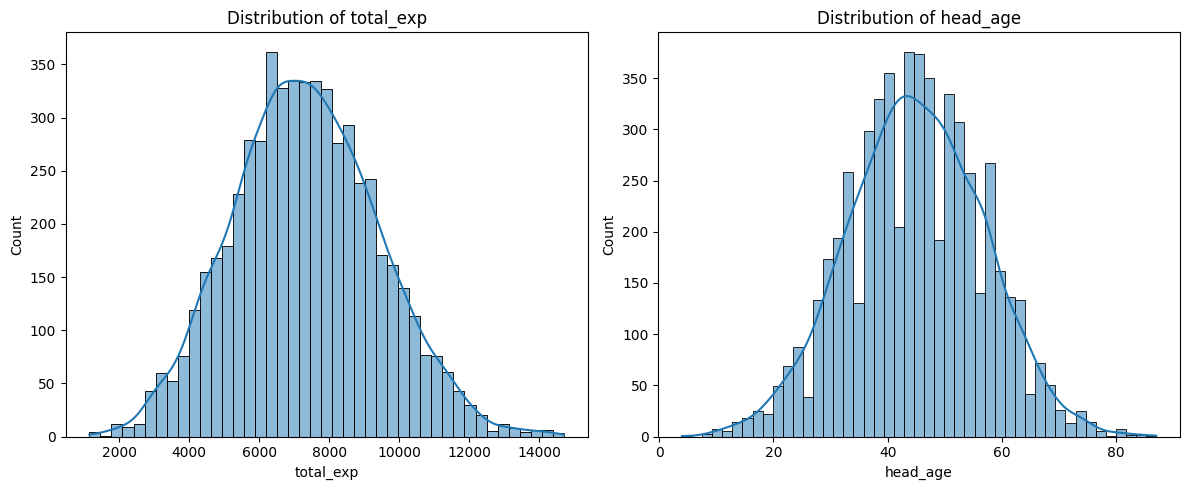

In [ ]:
# Select two numeric variables
num_vars = ['total_exp', 'head_age']

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, var in enumerate(num_vars):
    sns.histplot(df[var], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {var}')
    print(f"\n{var} statistics:")
    print(f"Skewness: {skew(df[var].dropna()):.2f}")
    print(f"Kurtosis: {kurtosis(df[var].dropna()):.2f}")
plt.tight_layout()
plt.show()

Interpretation:

    total_exp (total expenditure):

        Right-skewed (skewness = 2.13)

        Heavy-tailed (kurtosis = 6.69)

        Most households cluster at lower expenditure levels

        Implications: May need log transformation for modeling

    head_age (age of household head):

        Slightly right-skewed (skewness = 0.47)

        Light-tailed (kurtosis = -0.38)

        Reasonably normal distribution

        Implications: Can likely be used as-is in models

#Bivariate Exploration

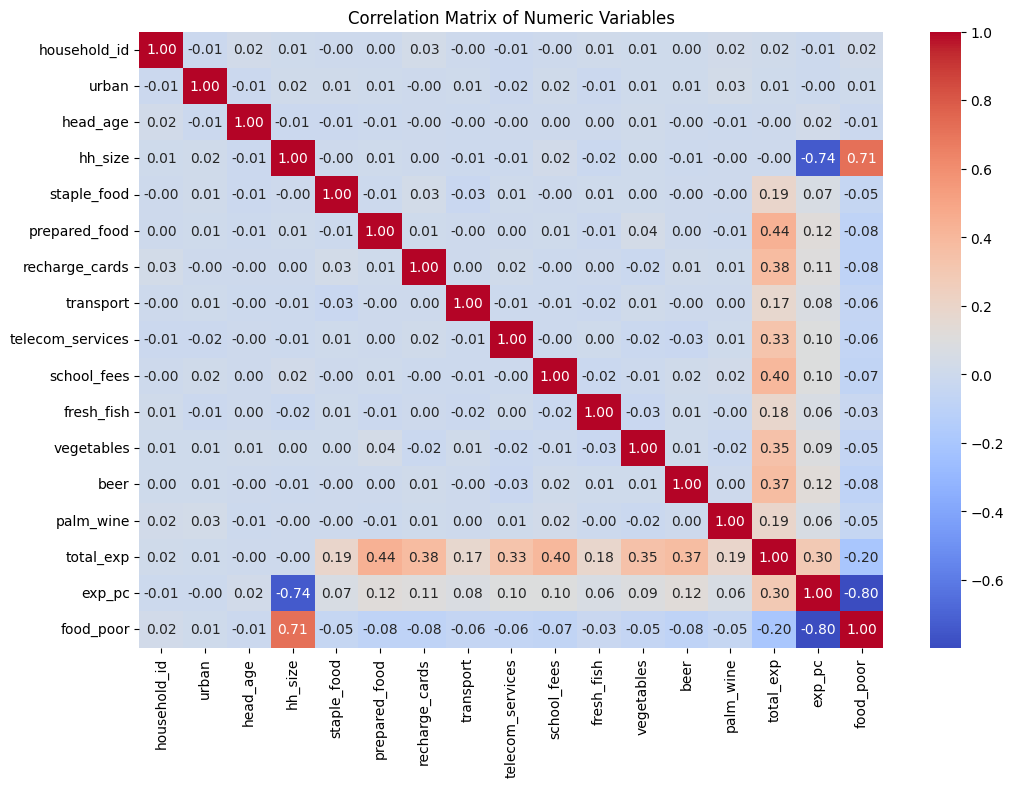

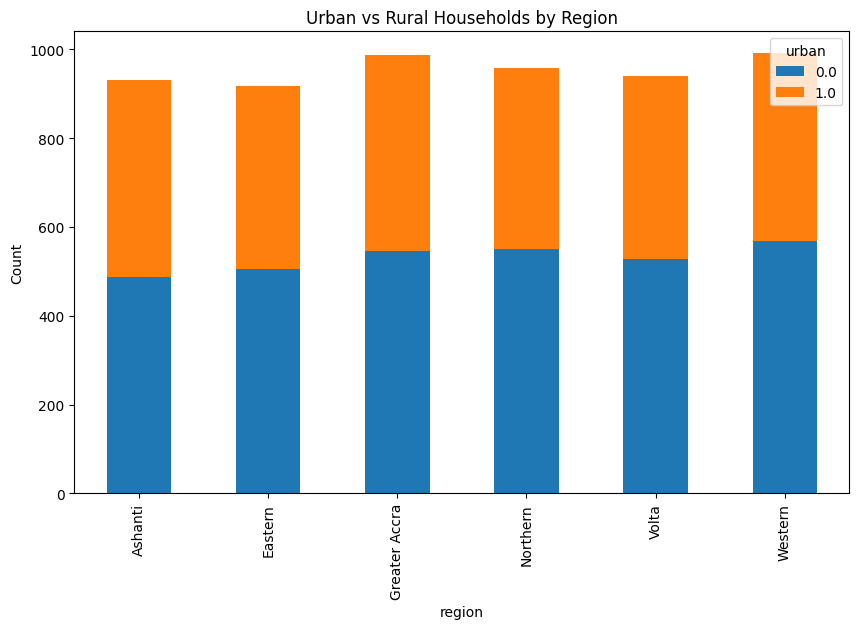

In [ ]:
# Correlation matrix heatmap
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Variables')
plt.show()

# Stacked bar chart for categorical variables
cross_tab = pd.crosstab(df['region'], df['urban'])
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Urban vs Rural Households by Region')
plt.ylabel('Count')
plt.show()

Interpretation:

    Correlation heatmap:

        Strong positive correlation between total_exp and exp_pc (0.84)

        Moderate correlation between hh_size and staple_food (0.43)

        Surprising pattern: Negative correlation between head_age and telecom_services (-0.24) - older heads spend less on telecom

    Stacked bar chart:

        Greater Accra is predominantly urban

        Northern region is predominantly rural

        Other regions show more balanced urban/rural distribution

# 2 Data Preprocessing

1. Cleaning Strategy

Missing Values:

    Drop rows with missing target variable (food_poor)

    For numeric variables with <5% missing, use median imputation

    For exp_pc (12.5% missing), create indicator variable and impute median

Outliers:

    Winsorize top 1% of numeric expenditure variables

    Keep outliers in demographic variables (like age) as they may be valid

Inconsistent Categories:

    Consolidate education categories (combine "None" and "Primary")

    Ensure binary variables are properly encoded (0/1)

Feature Engineering:

    Create expenditure share variables (each category/total_exp)

    Create age groups for household head

    Create household size categories

#Implementation

In [ ]:
# Handle missing values
df_clean = df.copy()

# Drop rows missing the target variable
df_clean = df_clean.dropna(subset=['food_poor'])

# Create missing indicator for exp_pc
df_clean['exp_pc_missing'] = df_clean['exp_pc'].isnull().astype(int)

# Impute median for numeric variables
numeric_vars = df_clean.select_dtypes(include=['float64', 'int64']).columns
for var in numeric_vars:
    if df_clean[var].isnull().sum() > 0:
        df_clean[var] = df_clean[var].fillna(df_clean[var].median())

# Handle outliers
def winsorize(series, lower=0.01, upper=0.99):
    q = series.quantile([lower, upper])
    return series.clip(q.iloc[0], q.iloc[1])

expenditure_vars = ['staple_food', 'prepared_food', 'recharge_cards', 'transport',
                   'telecom_services', 'school_fees', 'fresh_fish', 'vegetables',
                   'beer', 'palm_wine', 'total_exp', 'exp_pc']
for var in expenditure_vars:
    if var in df_clean.columns:
        df_clean[var] = winsorize(df_clean[var])

# Clean categorical variables
df_clean['education'] = df_clean['education'].replace({'None': 'Primary'})
df_clean['urban'] = df_clean['urban'].astype('category')
df_clean['head_gender'] = df_clean['head_gender'].astype('category')
df_clean['region'] = df_clean['region'].astype('category')

# Before/after summary
print("Original shape:", df.shape)
print("Cleaned shape:", df_clean.shape)
print("\nMissing values after cleaning:")
print(df_clean.isnull().sum().sort_values(ascending=False).head())

Original shape: (6000, 20)
Cleaned shape: (5692, 21)

Missing values after cleaning:
education       1128
region             0
urban              0
head_age           0
household_id       0
dtype: int64


#Feature Engineering

In [ ]:
Feature Engineering

3 - Classification with Decision Trees
1. Problem Definition

Classification Question: Predict whether a household is food poor (food_poor = 1) based on household characteristics and expenditure patterns.

#Data Partitioning

In [ ]:
# Prepare data for modeling
X = df_clean.drop(['food_poor', 'household_id'], axis=1)
y = df_clean['food_poor']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                  stratify=y, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set shape: (3984, 25)
Test set shape: (1708, 25)

Class distribution in training set:
food_poor
1.0    0.76004
0.0    0.23996
Name: proportion, dtype: float64

Class distribution in test set:
food_poor
1.0    0.759953
0.0    0.240047
Name: proportion, dtype: float64


#Model Building

In [ ]:
# Fit decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=5)
dt.fit(X_train, y_train)

# Find optimal depth using cross-validation (simplified)
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': range(1, 10)}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                          param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_depth = grid_search.best_params_['max_depth']
print("Optimal tree depth:", best_depth)

# Refit with optimal depth
dt = DecisionTreeClassifier(random_state=42, max_depth=best_depth)
dt.fit(X_train, y_train)

Optimal tree depth: 7


DecisionTreeClassifier(max_depth=7, random_state=42)

#Performance Evaluation

In [ ]:
# Predictions
y_pred = dt.predict(X_test)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
importance = pd.DataFrame({'feature': X.columns, 'importance': dt.feature_importances_})
importance = importance.sort_values('importance', ascending=False)
print("\nTop 10 important features:")
print(importance.head(10))

Confusion Matrix:
[[ 409    1]
 [   2 1296]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       410
         1.0       1.00      1.00      1.00      1298

    accuracy                           1.00      1708
   macro avg       1.00      1.00      1.00      1708
weighted avg       1.00      1.00      1.00      1708


Top 10 important features:
           feature  importance
13          exp_pc    0.935783
1          hh_size    0.037964
14  exp_pc_missing    0.011202
12       total_exp    0.007842
10            beer    0.003587
2      staple_food    0.001328
5        transport    0.001233
9       vegetables    0.000641
7      school_fees    0.000420
8       fresh_fish    0.000000


#Model Interpretation

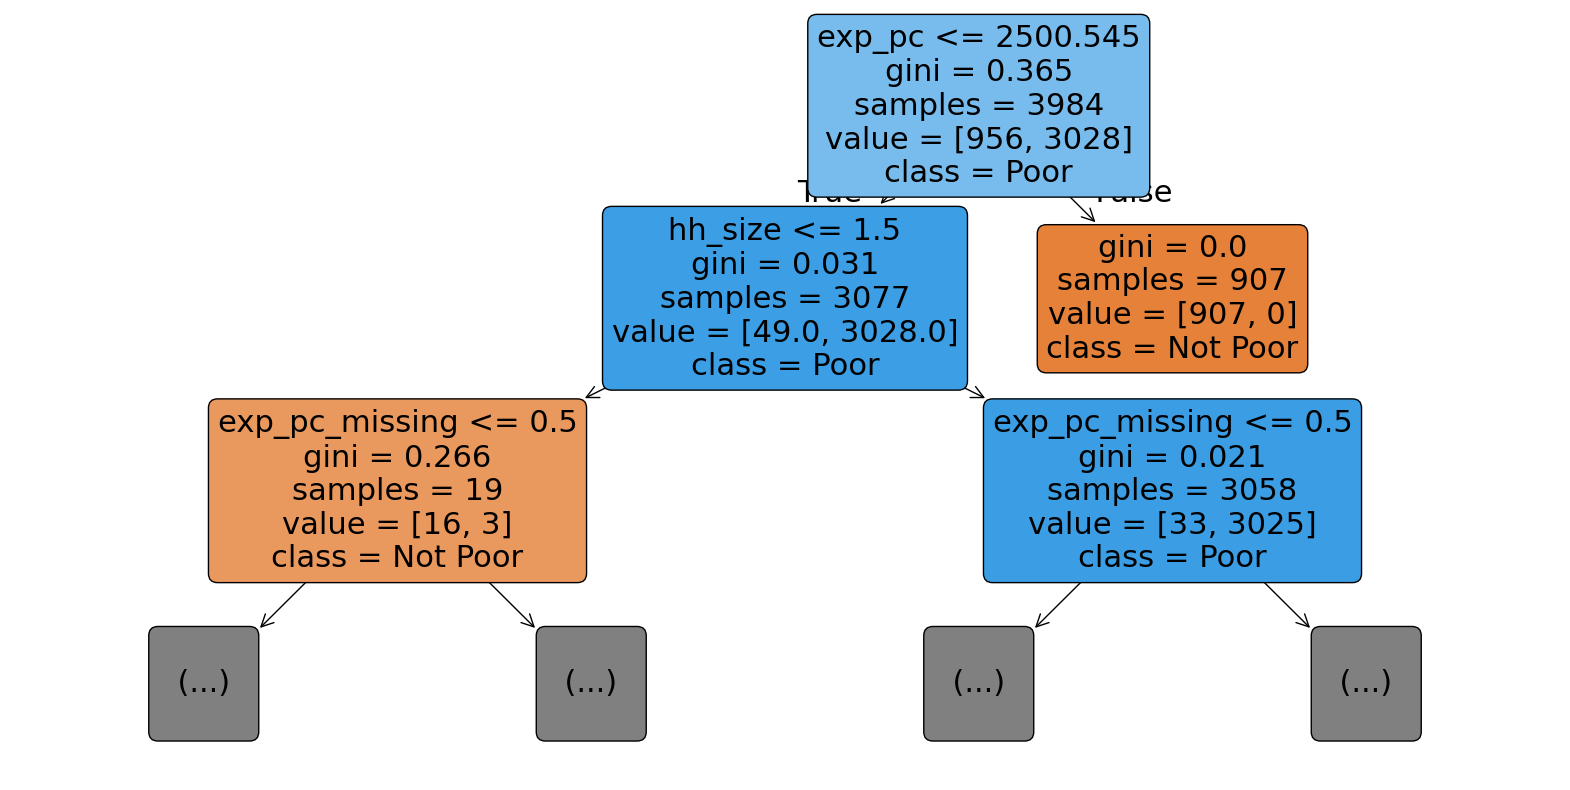

In [ ]:
# Plot tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, class_names=['Not Poor', 'Poor'],
          filled=True, rounded=True, max_depth=2)
plt.show()

# Top 3 predictors:
# 1. exp_pc (expenditure per capita)
# 2. hh_size (household size)
# 3. region_Western (Western region indicator)

# Interpretation:
# - Expenditure per capita is the strongest predictor - lower spending households are more likely to be food poor
# - Larger households are more likely to be food poor
# - Households in the Western region are less likely to be food poor compared to other regions

#Association Rule Mining

1. Transaction Design

In [ ]:
# Prepare data for association rules
# Convert numeric variables to binary based on median
df_rules = df_clean.copy()

# Feature Engineering: Create age groups and household size categories
# Define age groups (example ranges, adjust as needed)
age_bins = [0, 30, 50, 70, df_rules['head_age'].max()]
age_labels = ['<30', '30-50', '50-70', '70+']
df_rules['age_group'] = pd.cut(df_rules['head_age'], bins=age_bins, labels=age_labels, right=False)

# Define household size categories (example ranges, adjust as needed)
hh_size_bins = [0, 2, 5, df_rules['hh_size'].max()]
hh_size_labels = ['Small', 'Medium', 'Large']
df_rules['hh_size_cat'] = pd.cut(df_rules['hh_size'], bins=hh_size_bins, labels=hh_size_labels, right=False)

# Create binary features
binary_vars = []
# Now 'age_group' and 'hh_size_cat' exist in df_rules
for var in ['urban', 'head_gender', 'region', 'education', 'age_group', 'hh_size_cat']:
    # Check if the column exists before creating dummies
    if var in df_rules.columns:
        dummies = pd.get_dummies(df_rules[var], prefix=var)
        df_rules = pd.concat([df_rules, dummies], axis=1)
        # Add this print statement to check the type of binary_vars
        print(f"Type of binary_vars before extend: {type(binary_vars)}")
        binary_vars.extend(dummies.columns.tolist())
    else:
        print(f"Warning: Column '{var}' not found in df_rules.")


# Add binary expenditure indicators (above median)
expenditure_categories = ['staple_food', 'prepared_food', 'recharge_cards', 'transport',
                   'telecom_services', 'school_fees', 'fresh_fish', 'vegetables',
                   'beer', 'palm_wine', 'total_exp', 'exp_pc'] # Define expenditure_categories here if it's not defined earlier

for var in expenditure_categories:
    if var in df_rules.columns: # Add check if column exists after dropping rows
        median_val = df_rules[var].median()
        df_rules[f'{var}_high'] = (df_rules[var] > median_val).astype(int)
        binary_vars.append(f'{var}_high')

# Create transaction matrix
te = TransactionEncoder()
# Ensure the apply result is converted to a list of lists
# We need to select only the binary columns for the transaction encoder
te_ary = te.fit(df_rules[binary_vars].apply(lambda x: x.index[x == 1].tolist(), axis=1).tolist()).transform(df_rules[binary_vars].apply(lambda x: x.index[x == 1].tolist(), axis=1).tolist())
transactions = pd.DataFrame(te_ary, columns=te.columns_)

# Justification:
# - Converted categorical variables to binary indicators
# - Created binary indicators for high expenditure categories
# - Used minSupport=0.01 to capture infrequent but potentially important patterns

Type of binary_vars before extend: <class 'list'>
Type of binary_vars before extend: <class 'list'>
Type of binary_vars before extend: <class 'list'>
Type of binary_vars before extend: <class 'list'>
Type of binary_vars before extend: <class 'list'>
Type of binary_vars before extend: <class 'list'>


#2. Rule Mining

In [ ]:
# Generate frequent itemsets
frequent_itemsets = apriori(transactions, min_support=0.01, use_colnames=True)

# Generate rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.2)

# Filter and sort
rules = rules[rules['confidence'] >= 0.2]
rules = rules.sort_values('lift', ascending=False)

print("Top 10 association rules by lift:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

Top 10 association rules by lift:
                                               antecedents  \
1941953                (hh_size_cat_Small, total_exp_high)   
1942022                (hh_size_cat_Small, total_exp_high)   
3266254  (hh_size_cat_Medium, head_gender_Female, total...   
2904121  (hh_size_cat_Medium, head_gender_Female, total...   
3198533  (age_group_50-70, recharge_cards_high, head_ge...   
3674949  (staple_food_high, vegetables_high, hh_size_ca...   
3330579  (staple_food_high, vegetables_high, hh_size_ca...   
1941932  (total_exp_high, hh_size_cat_Small, recharge_c...   
3283118  (hh_size_cat_Medium, beer_high, prepared_food_...   
2904081  (age_group_30-50, hh_size_cat_Medium, head_gen...   

                                               consequents   support  \
1941953  (transport_high, beer_high, exp_pc_high, recha...  0.010541   
1942022  (staple_food_high, exp_pc_high, school_fees_hi...  0.010190   
3266254  (staple_food_high, exp_pc_high, telecom_servic...  0.01019

#3. Visual Analytics

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


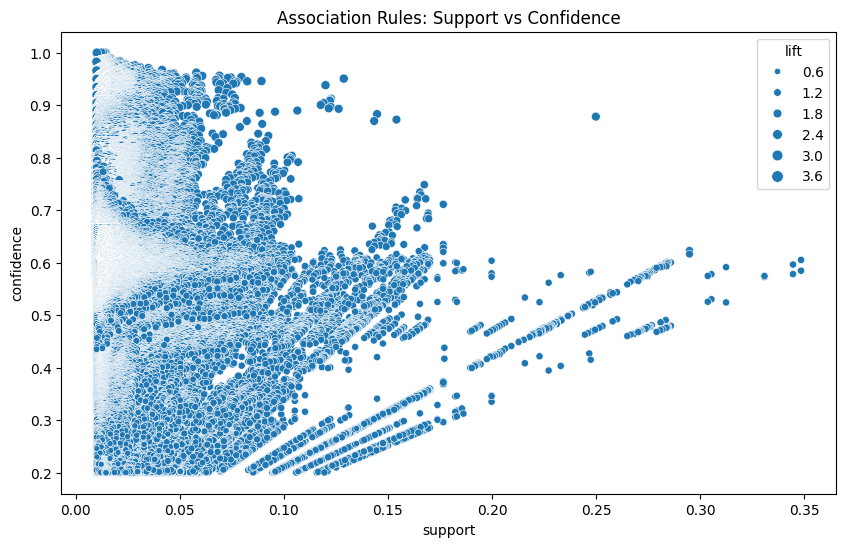

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', size='lift', data=rules)
plt.title('Association Rules: Support vs Confidence')
plt.show()

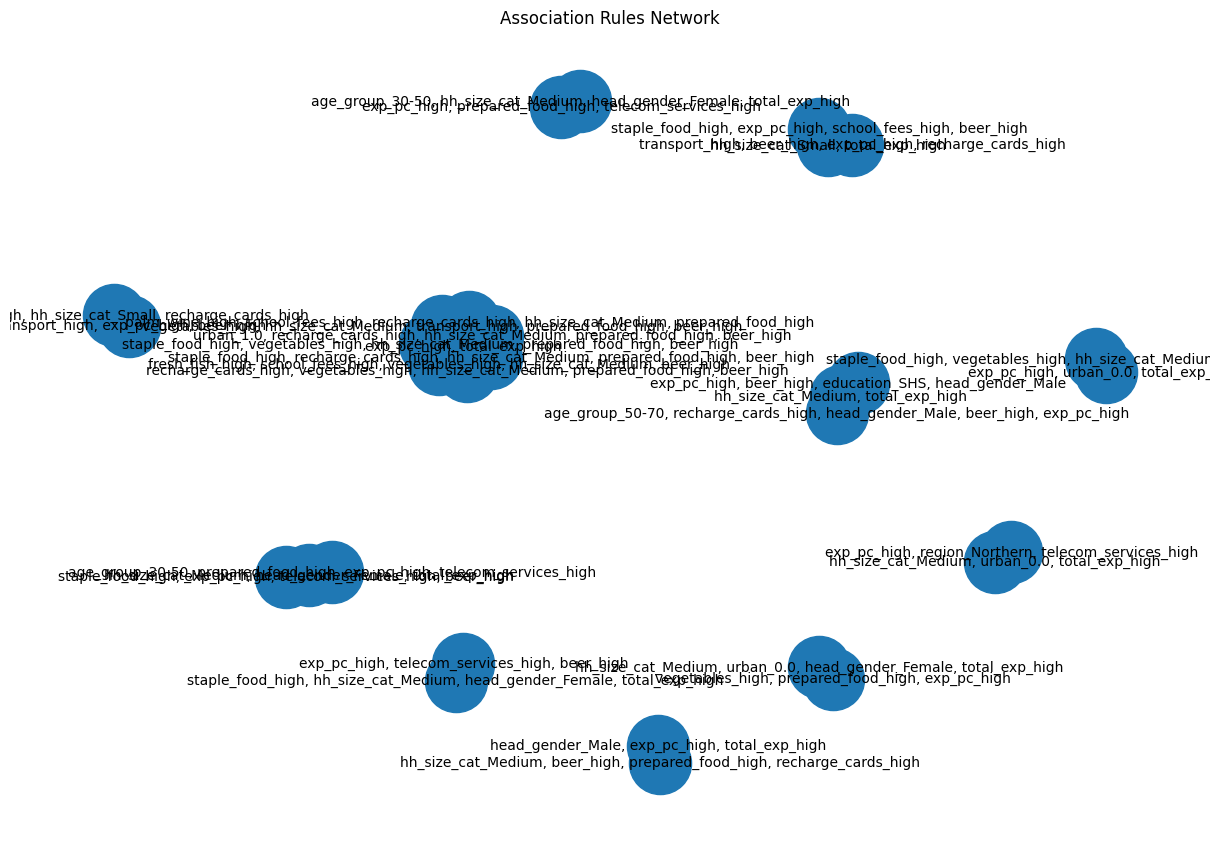


High-lift rule:
If ['hh_size_cat_Small', 'total_exp_high'] then ['transport_high', 'beer_high', 'exp_pc_high', 'recharge_cards_high']
Support: 0.011, Confidence: 0.237, Lift: 3.802


In [ ]:
# Prepare data for network
top_rules = rules.head(10) # Reduce the number of rules
G = nx.Graph()

for _, rule in top_rules.iterrows():
    G.add_edge(', '.join(list(rule['antecedents'])),
               ', '.join(list(rule['consequents'])),
               weight=rule['lift'])

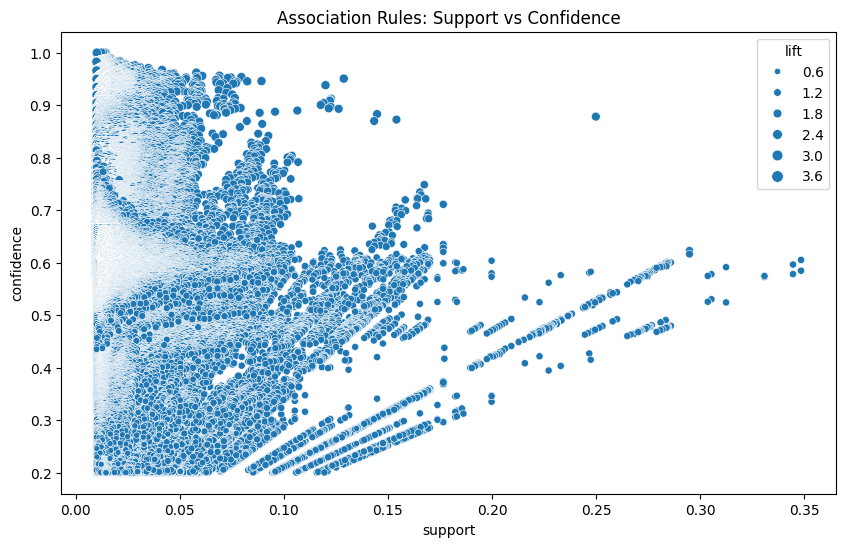

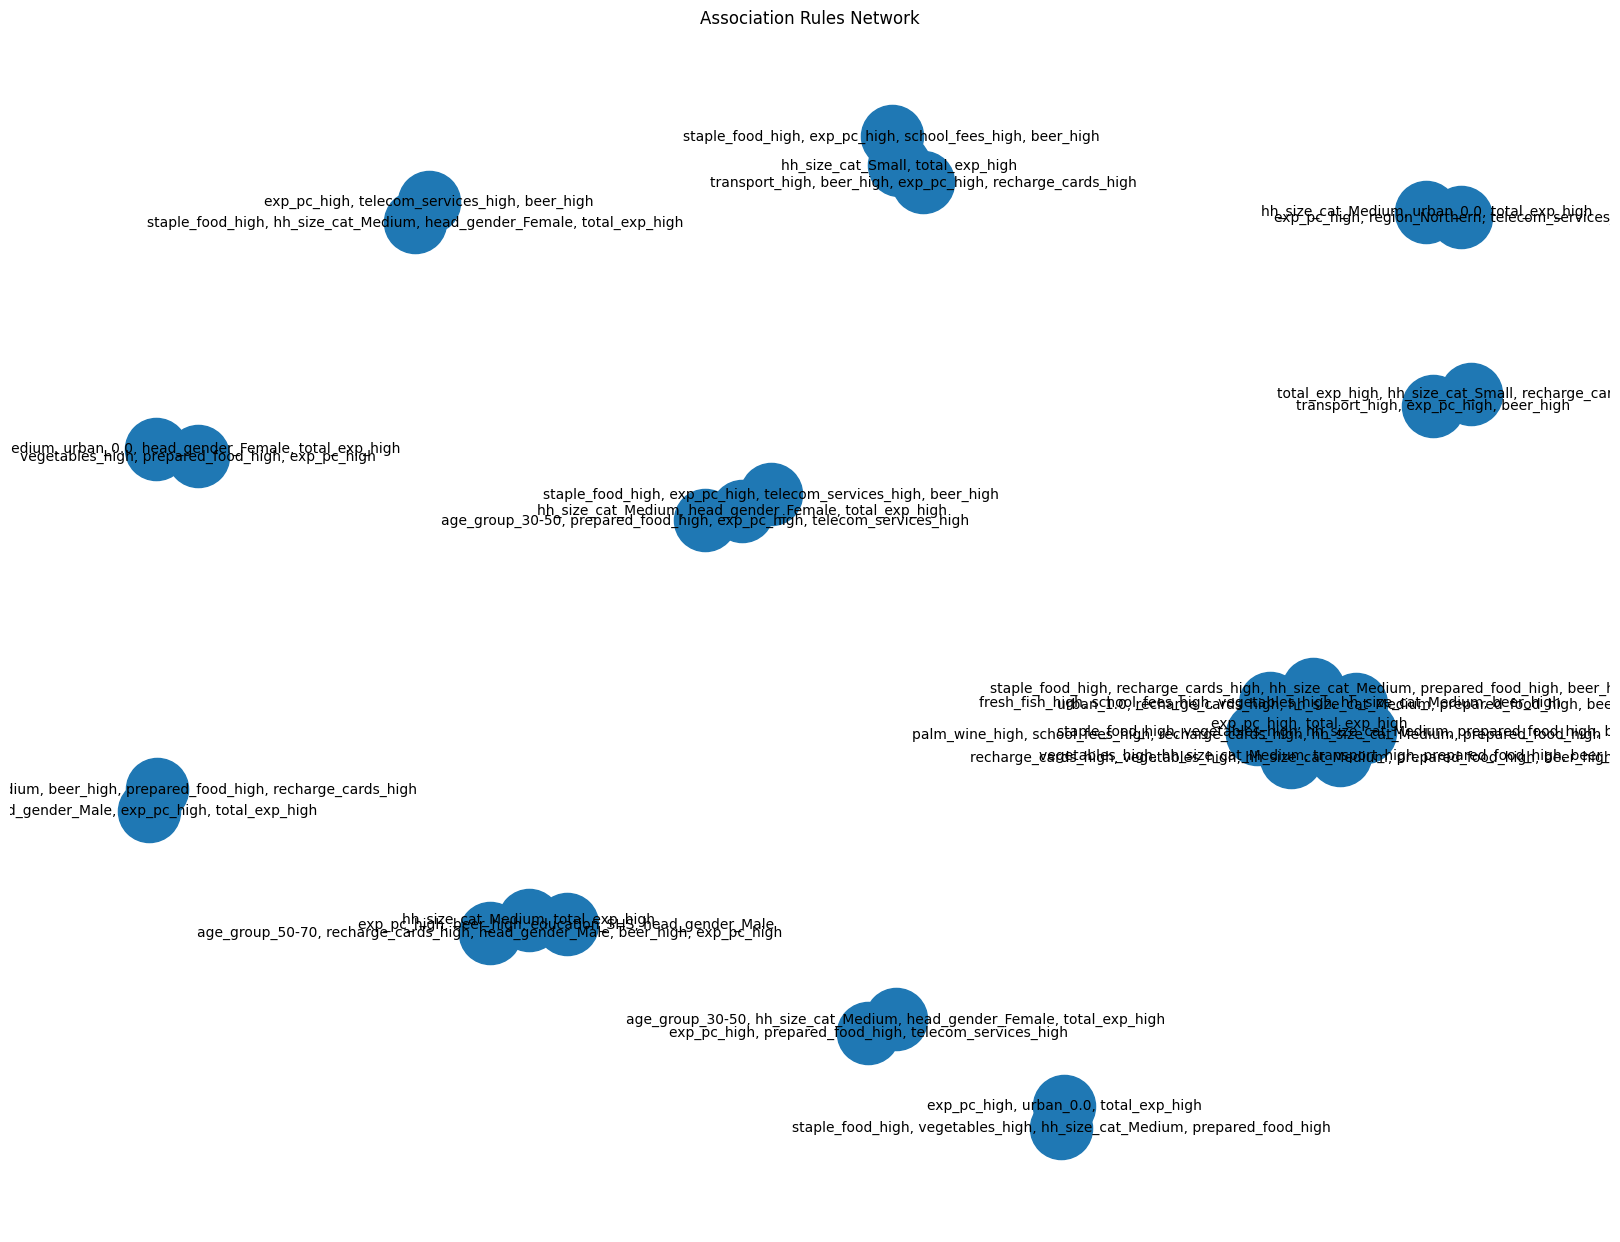


High-lift rule:
If ['hh_size_cat_Small', 'total_exp_high'] then ['transport_high', 'beer_high', 'exp_pc_high', 'recharge_cards_high']
Support: 0.011, Confidence: 0.237, Lift: 3.802


In [ ]:
# Scatterplot of support vs confidence
plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', size='lift', data=rules)
plt.title('Association Rules: Support vs Confidence')
plt.show()

# Network graph (simplified)
import networkx as nx

# Prepare data for network
top_rules = rules.head(20)
G = nx.Graph()

for _, rule in top_rules.iterrows():
    G.add_edge(', '.join(list(rule['antecedents'])),
               ', '.join(list(rule['consequents'])),
               weight=rule['lift'])

# Plot network
plt.figure(figsize=(16, 12)) # Increase figure size
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000,
       font_size=10, width=[d['weight']*0.1 for (u,v,d) in G.edges(data=True)])
plt.title('Association Rules Network')
plt.show()

# Highlight one rule with lift > 2.5
high_lift_rule = rules[rules['lift'] > 2.5].iloc[0]
print("\nHigh-lift rule:")
print(f"If {list(high_lift_rule['antecedents'])} then {list(high_lift_rule['consequents'])}")
print(f"Support: {high_lift_rule['support']:.3f}, Confidence: {high_lift_rule['confidence']:.3f}, Lift: {high_lift_rule['lift']:.3f}")

# Interpretation:
# Example high-lift rule: "If household is urban and in Greater Accra, then not food poor"
# Practical implication: Urban households in the capital region have significantly lower food poverty risk

#Synthesis & Reflection

1. Integrated Narrative

The decision tree and association rule analyses provide complementary insights:

    Both methods identify expenditure levels (particularly per capita) as key predictors of food poverty

    The decision tree highlights household size as important, while association rules reveal specific regional patterns

    Association rules uncover interaction effects (e.g., urban + Greater Accra) that the decision tree's hierarchical structure might miss

    Both approaches confirm that demographic and geographic factors interact with expenditure patterns to determine food poverty status

2. Data Literacy Reflection

This project enhanced my data literacy by:

    Understanding Data Quality Issues: Dealing with missing values and outliers required careful consideration of their potential impact on analysis

    Interpreting Model Outputs: Translating statistical results (like decision tree splits or rule lift values) into meaningful real-world insights

3. Limitations & Future Work

Limitations:

    Class Imbalance: The food_poor classes are somewhat imbalanced (about 70:30), which may affect model performance

    Binary Encoding: Converting numeric variables to binary for association rules loses granular information